In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, trange
from torchvision import transforms
import torchvision


import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

c:\Users\nnurs\anaconda3\envs\pytorchenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ReLUSquared(nn.Module):
    def forward(self, x):
        return torch.relu(x) ** 2

In [3]:
input_size = 3
hidden_size = 8
num_layers = 16

In [4]:
import torch
import torch.jit as jit
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import numbers
from typing import List, Tuple

class LayerNorm(jit.ScriptModule):
    def __init__(self, normalized_shape):
        super().__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = Parameter(torch.ones(normalized_shape))
        self.bias = Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    @jit.script_method
    def compute_layernorm_stats(self, input):
        mu = input.mean(-1, keepdim=True)
        sigma = input.std(-1, keepdim=True, unbiased=False)
        return mu, sigma

    @jit.script_method
    def forward(self, input):
        mu, sigma = self.compute_layernorm_stats(input)
        return (input - mu) / sigma * self.weight + self.bias


class LayerNormLSTMCell(jit.ScriptModule):
    def __init__(self, input_size, hidden_size, decompose_layernorm=False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = Parameter(torch.randn(4 * hidden_size, hidden_size))

        if decompose_layernorm:
            ln = LayerNorm
        else:
            ln = nn.LayerNorm

        self.layernorm_i = ln(4 * hidden_size)
        self.layernorm_h = ln(4 * hidden_size)
        self.layernorm_c = ln(hidden_size)

    @jit.script_method
    def forward(
        self, input: Tensor, state: Tuple[Tensor, Tensor]
    ) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:
        hx, cx = state
        igates = self.layernorm_i(torch.mm(input, self.weight_ih.t()))
        hgates = self.layernorm_h(torch.mm(hx, self.weight_hh.t()))
        gates = igates + hgates
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = self.layernorm_c((forgetgate * cx) + (ingate * cellgate))
        hy = outgate * torch.tanh(cy)

        return hy, (hy, cy)


class LSTMLayer(jit.ScriptModule):
    def __init__(self, cell, *cell_args):
        super().__init__()
        self.cell = cell(*cell_args)

    @jit.script_method
    def forward(
        self, input: Tensor, state: Tuple[Tensor, Tensor]
    ) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:
        inputs = input.unbind(0)
        outputs = torch.jit.annotate(List[Tensor], [])
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs += [out]
        return torch.stack(outputs), state

```
Shape should be 
batch, H*W, embed_size
```

In [5]:
custom_lstm = ImageCustomLSTM(input_size, hidden_size, num_layers)
total_params = sum(p.numel() for p in custom_lstm.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 8634


In [6]:
def get_gradient_norms(model):
    grad_norms = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norms[name] = param.grad.norm().item()
    return grad_norms

In [7]:
activation_maps = {}

In [8]:
def hook_fn(module, input, output, number):
    layer_name = f'{module.__class__.__name__}_{number}'
    activation_maps[layer_name] = output[0].mean(dim=0)        

def register_hooks(model):
    model.layers[0].act.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 1))
    model.layers[4].act.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 5))
    model.layers[10].act.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 11))
    model.layers[15].act.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 16)) 

def save_activation_maps(epoch):
    for layer_name, activation in activation_maps.items():
        activation = activation.detach().cpu().numpy() 
        plt.figure(figsize=(10, 5))
        plt.imshow(activation, cmap='viridis')
        plt.title(f'Activation Map for {layer_name} at Epoch {epoch}')
        plt.colorbar()
        plt.savefig(f'{PREFIX}/{layer_name}_activation_map_epoch_{epoch}.png')  
        plt.close()

In [9]:
batch_size = 64
learning_rate = 0.001
num_epochs = 800

# CIFAR-10 Data Loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet18 requires 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./cifar', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def train(model, checkpoint=None):  

    model = model.to(device)
    N_EPOCHS = 10

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
 
    training_losses = []

    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for i, batch in tqdm(enumerate(trainloader), desc=f"Epoch {epoch + 1} in training", leave=False):

            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(trainloader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # if epoch % 100 == 0:
        if True:

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss, 
                'training_losses': training_losses
            }

            torch.save(checkpoint, 'checkpoint.pt')

            save_activation_maps(epoch)


        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
        print()


        training_losses.append(train_loss)

    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(testloader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(testloader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)

    return test_loss, correct, total, training_losses

In [11]:
model = ImageCustomLSTM(input_size, hidden_size, num_layers)
model

ImageCustomLSTM(
  (layers): ModuleList(
    (0): CustomLSTMCell(
      (W_i): Linear(in_features=11, out_features=8, bias=True)
      (W_f): Linear(in_features=11, out_features=8, bias=True)
      (W_c): Linear(in_features=11, out_features=8, bias=True)
      (W_o): Linear(in_features=11, out_features=8, bias=True)
      (tanh): Tanh()
      (act): Sigmoid()
    )
    (1-15): 15 x CustomLSTMCell(
      (W_i): Linear(in_features=16, out_features=8, bias=True)
      (W_f): Linear(in_features=16, out_features=8, bias=True)
      (W_c): Linear(in_features=16, out_features=8, bias=True)
      (W_o): Linear(in_features=16, out_features=8, bias=True)
      (tanh): Tanh()
      (act): Sigmoid()
    )
  )
  (head): Linear(in_features=8, out_features=10, bias=True)
)

In [12]:
PREFIX = 'rnn_base'

model = ImageCustomLSTM(input_size, hidden_size, num_layers)
register_hooks(model)

test_loss, correct, total, training_losses = train(model)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.28
Test accuracy: 92.04%


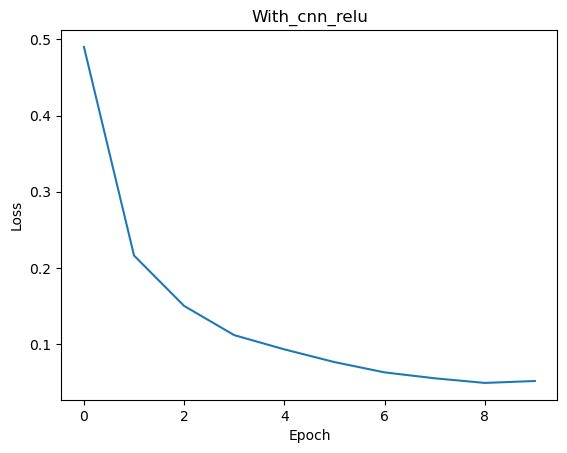

In [ ]:
print(f"Test loss: {test_loss:.2f}")
print(f"Test accuracy: {correct / total * 100:.2f}%")

plt.title(f"With_{PREFIX}")
plt.xlabel("Epoch")
plt.ylabel("Loss")   

plt.plot(training_losses) 
plt.savefig(f"training_losses_w_{PREFIX}.png") 
plt.show()


with open(f"{PREFIX}.txt", 'a') as f:
    f.write(f"Test loss: {test_loss:.2f}\n")
    f.write(f"Test accuracy: {correct / total * 100:.2f}%\n")